# Analyse different model predictions

In [1]:
categories = {
    "Sports": [
        "Archery",
        "BaseballPitch",
        "Basketball",
        "Shooting", 
        "BenchPress", 
        "Biking", 
        "Billiards", 
        "BreastStroke",
        "CleanAndJerk", 
        "Diving", 
        "Fencing", 
        "GolfSwing",
        "HighJump", 
        "HorseRace", 
        "HorseRiding", 
        "JavelinThrow", 
        "Kayaking",
        "PoleVault", 
        "PommelHorse", 
        "Punch", 
        "Rowing", 
        "Skiing", 
        "Skijet", 
        "TennisSwing", 
        "ThrowDiscus", 
        "VolleyballSpiking",
        "BalanceBeam", 
        "BasketballDunk", 
        "Bowling", 
        "BoxingPunchingBag", 
        "BoxingSpeedBag",
        "CliffDiving", 
        "CricketBowling", 
        "CricketShot",
        "FieldHockeyPenalty", 
        "FloorGymnastics",
        "FrisbeeCatch", 
        "FrontCrawl", 
        "HammerThrow", 
        "IceDancing", 
        "LongJump", 
        "ParallelBars", 
        "Rafting",
        "Shotput", 
        "SkyDiving", 
        "SoccerPenalty", 
        "StillRings", 
        "SumoWrestling", 
        "Surfing", 
        "TableTennisShot", 
        "UnevenBars"
    ],
    "Human-Object Interaction": [
        "HulaHoop",
        "JugglingBalls",
        "JumpRope",
        "Mixing", 
        "Nunchucks",
        "PizzaTossing",
        "SkateBoarding",
        "SoccerJuggling",
        "YoYo",
        "ApplyEyeMakeup", 
        "ApplyLipstick",
        "BlowDryHair",
        "BrushingTeeth",
        "Hammering",
        "Knitting",
        "MoppingFloor",
        "CuttingInKitchen",
        "ShavingBeard",
        "WritingOnBoard",
        "Typing",
    ],
    "Human-Human Interaction": [
        "MilitaryParade",
        "SalsaSpin",
        "BandMarching",
        "Haircut",
        "HeadMassage",
    ],
    "Body-Motion Only": [
        "PushUps", 
        "RockClimbingIndoor", 
        "RopeClimbing",
        "PullUps",
        "JumpingJack",
        "Lunges",
        "Swing", 
        "TaiChi",
        "TrampolineJumping",
        "WalkingWithDog",
        "BlowingCandles", 
        "BodyWeightSquats",
        "BabyCrawling", 
        "HandstandPushups", 
        "HandstandWalking",
        "WallPushups"
    ],
    "Playing Musical Instruments": [
        "Drumming",
        "PlayingGuitar", 
        "PlayingPiano", 
        "PlayingTabla", 
        "PlayingViolin",
        "PlayingCello", 
        "PlayingDaf", 
        "PlayingDhol",
        "PlayingFlute", 
        "PlayingSitar"
    ]
}

In [1]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import torch
import joblib
from models import VideoSwin, R2Plus1D, CnnGru
from data import SWIN_UCF101, VIDEOSWIN_NORM, BaselineUCF101
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
import os
import pickle

batch_size = 32
num_workers = 4


def get_metrics(true, pred):
    return {"accuracy": accuracy_score(true, pred), "f1": f1_score(true, pred, average="weighted")}

def get_preds(model, dataloader):
    preds = []
    true = []
    
    model.eval()
    if torch.cuda.is_available():
        model = model.cuda()
    
    with torch.no_grad():
        for data in tqdm(dataloader, total=len(dataloader)):
            
            if isinstance(data, dict):
                X, y = data["pixel_values"], data["label"]
            else:
                X, y = data
                
            if torch.cuda.is_available():
                X = X.cuda()
                
            if isinstance(data, dict):
                out = model(X).logits
            else:
                out = model(X)
                
            preds.extend(out.max(1).indices.tolist())
            true.extend(y.tolist())
            
    model.train()
            
    return preds, true

## Get Swin predictions (MobileNet features, K-Means)

In [2]:
if os.path.exists("predictions/swin_mobilenet_kmeans.pkl"):
    with open('predictions/swin_mobilenet_kmeans.pkl', 'rb') as f:
        swin_kmeans_preds = pickle.load(f)

    with open('predictions/true.pkl', 'rb') as f:
        true = pickle.load(f)

else:
    batch_size = 4
    num_workers = 4
    
    test_kfs = joblib.load("keyframes/test_01_32frames.pkl") 

    model = VideoSwin('./swin/checkpoints/swin_base_patch244_window1677_sthv2.pth', 
                    101,
                    0.15,
                    embed_dim=128, 
                    depths=[2, 2, 18, 2], 
                    num_heads=[4, 8, 16, 32], 
                    patch_size=(2,4,4), 
                    window_size=(16,7,7), 
                    drop_path_rate=0.4, 
                    patch_norm=True)
    
    model.load_state_dict(torch.load('state_dicts/swin_mobilenet_kmeans.pth'))

    dataset_test = SWIN_UCF101('UCF-101', 'ucfTrainTestlist', 1, False, normalize=VIDEOSWIN_NORM, frame_sampler=test_kfs)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    swin_kmeans_preds, true = get_preds(model, test_dataloader)
    
    with open('predictions/swin_mobilenet_kmeans.pkl', 'wb') as f:
        pickle.dump(swin_kmeans_preds, f)

    with open('predictions/true.pkl', 'wb') as f:
        pickle.dump(true, f)

## Get Swin predictions (MobileNet features, Agglomerative)

In [3]:
if os.path.exists("predictions/swin_mobilenet_agg.pkl"):
    with open('predictions/swin_mobilenet_agg.pkl', 'rb') as f:
        swin_agg_preds = pickle.load(f)

    with open('predictions/true.pkl', 'rb') as f:
        true = pickle.load(f)

else:
    batch_size = 4
    num_workers = 4
    
    test_kfs = joblib.load("keyframes/test_01_32frames_agglomerative.pkl") 

    model = VideoSwin('./swin/checkpoints/swin_base_patch244_window1677_sthv2.pth', 
                    101,
                    0.15,
                    embed_dim=128, 
                    depths=[2, 2, 18, 2], 
                    num_heads=[4, 8, 16, 32], 
                    patch_size=(2,4,4), 
                    window_size=(16,7,7), 
                    drop_path_rate=0.4, 
                    patch_norm=True)
    
    model.load_state_dict(torch.load('state_dicts/swin_mobilenet_agg.pth'))

    dataset_test = SWIN_UCF101('UCF-101', 'ucfTrainTestlist', 1, False, normalize=VIDEOSWIN_NORM, frame_sampler=test_kfs)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    swin_agg_preds, _ = get_preds(model, test_dataloader)
    
    with open('predictions/swin_mobilenet_agg.pkl', 'wb') as f:
        pickle.dump(swin_agg_preds, f)

## Get R2Plus1D Predictions

In [4]:
if os.path.exists("predictions/r2plus1d.pkl"):
    with open('predictions/r2plus1d.pkl', 'rb') as f:
        r2plus1d_preds = pickle.load(f)
        
else:
    batch_size = 32
    num_workers = 4
    
    model = R2Plus1D(num_classes=101, label_smoothing=0.15)
    model.load_state_dict(torch.load('state_dicts/r2plus1d.pth'))

    dataset_test = BaselineUCF101('UCF-101', 'ucfTrainTestlist', 1, False)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    r2plus1d_preds, _ = get_preds(model, test_dataloader)
    
    with open('predictions/r2plus1d.pkl', 'wb') as f:
        pickle.dump(r2plus1d_preds, f)

## Get GRU+CNN Predictions

In [5]:
if os.path.exists("predictions/cnn_gru.pkl"):
    with open('predictions/cnn_gru.pkl', 'rb') as f:
        cnn_gru_preds = pickle.load(f)
        
else:
    batch_size = 32
    num_workers = 4
    
    model = CnnGru(num_classes=101, label_smoothing=0.15)
    
    model.load_state_dict(torch.load('state_dicts/cnn_gru.pth'))

    dataset_test = BaselineUCF101('UCF-101', 'ucfTrainTestlist', 1, False)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    cnn_gru_preds, _ = get_preds(model, test_dataloader)
    
    with open('predictions/cnn_gru.pkl', 'wb') as f:
        pickle.dump(cnn_gru_preds, f)

## Get ViViT (random initialization) preds

In [6]:
if os.path.exists("predictions/vivit_random.pkl"):
    with open('predictions/vivit_random.pkl', 'rb') as f:
        vivit_random_preds = pickle.load(f)
else:
    from data import VIVIT_UCF101
    from transformers import ViTFeatureExtractor#, Trainer, TrainingArguments
    from vivit_transformers import ViViTForImageClassification

    batch_size = 4
    num_workers = 4
    
    feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
    dataset_test = VIVIT_UCF101('UCF-101', 'ucfTrainTestlist', 1, False, feature_extractor=feature_extractor)

    model = ViViTForImageClassification.from_pretrained('./vivit_dino_32frames_random', num_labels=101)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    vivit_random_preds, _ = get_preds(model, test_dataloader)
    
    with open('predictions/vivit_random.pkl', 'wb') as f:
        pickle.dump(vivit_random_preds, f)

## Get ViViT preds

In [7]:
if os.path.exists("predictions/vivit.pkl"):
    with open('predictions/vivit.pkl', 'rb') as f:
        vivit_preds = pickle.load(f)
else:
    from data import VIVIT_UCF101
    from transformers import ViTFeatureExtractor#, Trainer, TrainingArguments
    from vivit_transformers import ViViTForImageClassification

    batch_size = 4
    num_workers = 4
    
    feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
    dataset_test = VIVIT_UCF101('UCF-101', 'ucfTrainTestlist', 1, False, feature_extractor=feature_extractor)

    model = ViViTForImageClassification.from_pretrained('./vivit_dino_32frames', num_labels=101)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    vivit_preds, _ = get_preds(model, test_dataloader)
    
    with open('predictions/vivit.pkl', 'wb') as f:
        pickle.dump(vivit_preds, f)

## Get ViViT preds (MobileNet features, K-Means)

In [8]:
if os.path.exists("predictions/vivit_mobilenet_kmeans.pkl"):
    with open('predictions/vivit_mobilenet_kmeans.pkl', 'rb') as f:
        vivit_kmeans_preds = pickle.load(f)
else:
    batch_size = 4
    num_workers = 4
    
    from data import VIVIT_UCF101
    from transformers import ViTFeatureExtractor
    from vivit_transformers import ViViTForImageClassification

    feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
    
    test_kfs = joblib.load("keyframes/test_01_32frames.pkl") 
    dataset_test = VIVIT_UCF101('UCF-101', 'ucfTrainTestlist', 1, False, feature_extractor=feature_extractor, frame_sampler=test_kfs, n_frames=32)

    model = ViViTForImageClassification.from_pretrained('./vivit_dino_32frames_kmeans', num_labels=101)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    vivit_kmeans_preds, _ = get_preds(model, test_dataloader)
    
    with open('predictions/vivit_mobilenet_kmeans.pkl', 'wb') as f:
        pickle.dump(vivit_kmeans_preds, f)

## Get ViViT preds (MobileNet features, K-Means, 10 frames)

In [12]:
if os.path.exists("predictions/vivit_mobilenet_kmeans_10frames.pkl"):
    with open('predictions/vivit_mobilenet_kmeans_10frames.pkl', 'rb') as f:
        vivit_10frames_kmeans_preds = pickle.load(f)
else:
    batch_size = 4
    num_workers = 4
    
    from data import VIVIT_UCF101
    from transformers import ViTFeatureExtractor
    from vivit_transformers import ViViTForImageClassification

    feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
    
    test_kfs = joblib.load("keyframes/test_01_10frames.pkl") 
    dataset_test = VIVIT_UCF101('UCF-101', 'ucfTrainTestlist', 1, False, feature_extractor=feature_extractor, frame_sampler=test_kfs)
    dataset_test.n_frames = 10

    model = ViViTForImageClassification.from_pretrained('./vivit_dino_10frames_kmeans', num_labels=101)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
    
    vivit_10frames_kmeans_preds, _ = get_preds(model, test_dataloader)
    
    with open('predictions/vivit_mobilenet_kmeans_10frames.pkl', 'wb') as f:
        pickle.dump(vivit_10frames_kmeans_preds, f)

  0%|          | 0/946 [00:00<?, ?it/s]

## Analyse predictions

In [7]:
idx2label = {}


# load the file with labels where each line contains a label and its ID (starting 1)
with open('ucfTrainTestlist/classInd.txt') as f:
    for l in f.readlines():
        l = l.strip()
        idx, label = l.split(" ")
        
        idx2label[int(idx)-1] = label # model outputs labels that start from 0, so substract 1

In [8]:
import pandas as pd
results = pd.DataFrame({
    'Swin': [idx2label[i] for i in swin_preds], 
    'R2Plus1D': [idx2label[i] for i in r2plus1d_preds], 
    'True': [idx2label[i] for i in true]
})

results.head(10)

,Swin,R2Plus1D,True
0,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
1,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
2,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
3,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
4,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
5,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
6,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
7,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
8,ApplyEyeMakeup,ApplyEyeMakeup,ApplyEyeMakeup
9,Haircut,ApplyEyeMakeup,ApplyEyeMakeup


In [39]:
# get data samples where Video Swin predicted correctly and R2Plus1D incorrectly
swin_correct = results[results.apply(lambda x: x["Swin"] == x["True"] and x["R2Plus1D"] != x["True"], axis=1)]
swin_correct

,Swin,R2Plus1D,True
54,ApplyLipstick,BrushingTeeth,ApplyLipstick
103,Archery,SalsaSpin,Archery
105,Archery,SalsaSpin,Archery
107,Archery,CuttingInKitchen,Archery
110,Archery,PlayingDhol,Archery
...,...,...,...
3754,YoYo,Nunchucks,YoYo
3756,YoYo,Nunchucks,YoYo
3757,YoYo,JugglingBalls,YoYo
3758,YoYo,JugglingBalls,YoYo


Text(0.5, 0.8, 'Video Swin (MobileNet features, Agg. Clustering) label: ApplyLipstick\nR2Plus1D (Baseline) label: BrushingTeeth\nTrue label: ApplyLipstick')

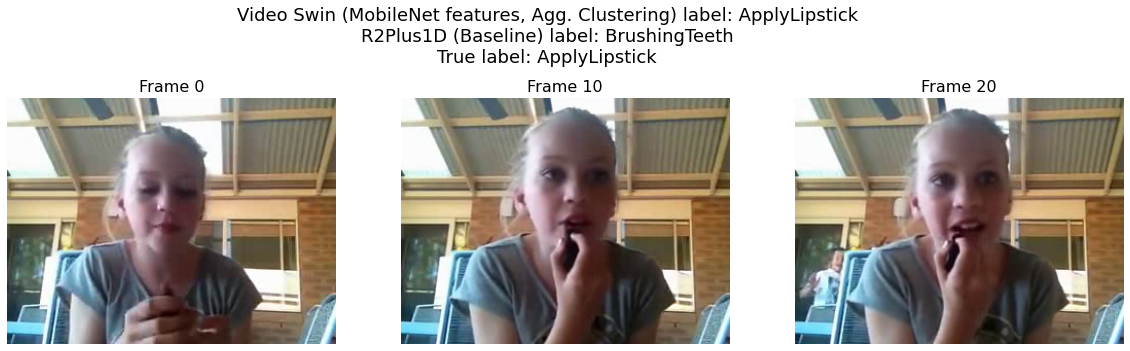

In [55]:
import matplotlib.pyplot as plt
from data import UCF101

dataset_test = UCF101('UCF-101', 'ucfTrainTestlist', 1, False)

sample_id = 0

incorrect_sample = swin_correct.iloc[sample_id]

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

idx = incorrect_sample.name
swin, r2plus1d, true = incorrect_sample

for i in range(3):
    frame = dataset_test[idx][0][i*10].transpose(0, -1).transpose(0, 1)
    ax[i].imshow(frame)
    ax[i].set_title(f'Frame {i*10}', fontsize=16)
        
for axis in ax.flatten():
    axis.set_axis_off()

fig.suptitle(f'Video Swin (MobileNet features, Agg. Clustering) label: {swin}\nR2Plus1D (Baseline) label: {r2plus1d}\nTrue label: {true}', y=0.8, fontsize=18)

fig.savefig('plots/swin_r2plus1d_pred1.png', dpi=300, bbox_inches='tight')

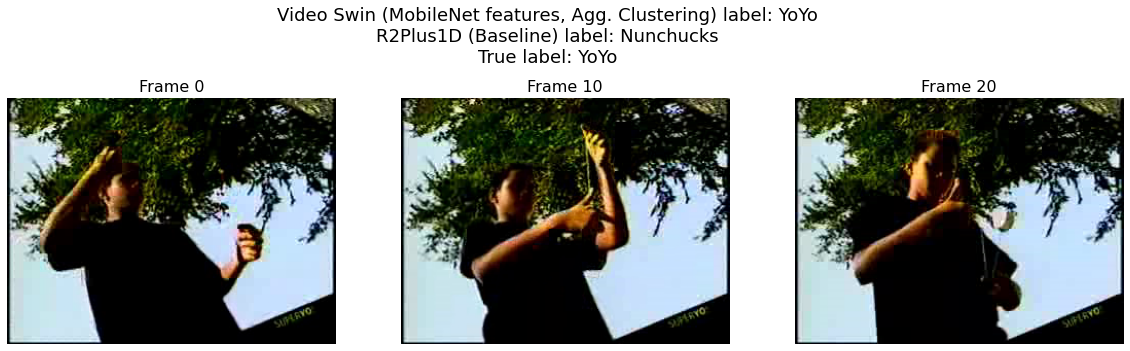

In [48]:
import matplotlib.pyplot as plt
from data import UCF101

dataset_test = UCF101('UCF-101', 'ucfTrainTestlist', 1, False)

sample_id = -1

incorrect_sample = swin_correct.iloc[sample_id]

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

idx = incorrect_sample.name
swin, r2plus1d, true = incorrect_sample

for i in range(3):
    frame = dataset_test[idx][0][i*10].transpose(0, -1).transpose(0, 1)
    ax[i].imshow(frame)
    ax[i].set_title(f'Frame {i*10}', fontsize=16)
        
for axis in ax.flatten():
    axis.set_axis_off()

fig.suptitle(f'Video Swin (MobileNet features, Agg. Clustering) label: {swin}\nR2Plus1D (Baseline) label: {r2plus1d}\nTrue label: {true}', y=0.8, fontsize=18)

fig.savefig('plots/swin_r2plus1d_pred2.png', dpi=300, bbox_inches='tight')

## Get per-category labels (+ confusion matrix)

In [12]:
# Map labels to label categories
label2categories = {label: cat for cat, labels in categories.items() for label in labels}
per_category = results[["Swin", "True"]].applymap(lambda x: label2categories[x])
per_category

,Swin,True
0,Human-Object Interaction,Human-Object Interaction
1,Human-Object Interaction,Human-Object Interaction
2,Human-Object Interaction,Human-Object Interaction
3,Human-Object Interaction,Human-Object Interaction
4,Human-Object Interaction,Human-Object Interaction
...,...,...
3778,Human-Object Interaction,Human-Object Interaction
3779,Human-Object Interaction,Human-Object Interaction
3780,Human-Object Interaction,Human-Object Interaction
3781,Human-Object Interaction,Human-Object Interaction


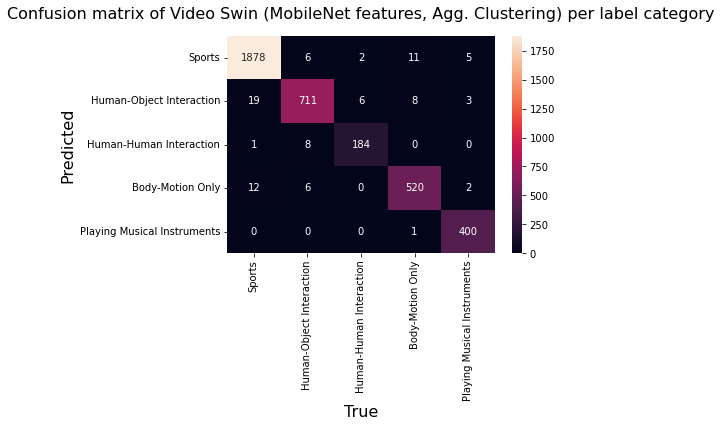

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_m = confusion_matrix(per_category["True"], per_category["Swin"], labels=list(categories.keys()))

ax = sns.heatmap(
    conf_m, 
    annot=True, 
    xticklabels=list(categories.keys()), 
    yticklabels=list(categories.keys()),
    fmt='g'
)

ax.set_xlabel("True", fontsize=16)
ax.set_ylabel("Predicted", fontsize=16)

plt.title("Confusion matrix of Video Swin (MobileNet features, Agg. Clustering) per label category", fontsize=16, y=1.05)
plt.savefig('plots/swin_confusion_matrix.png', dpi=300, bbox_inches='tight')


## Other analysis

In [15]:
# get samples where Video Swin was incorrect
swin_incorrect = results[results["Swin"] != results["True"]][["Swin", "True"]]
swin_incorrect

,Swin,True
9,Haircut,ApplyEyeMakeup
10,ApplyLipstick,ApplyEyeMakeup
13,ApplyLipstick,ApplyEyeMakeup
53,BrushingTeeth,ApplyLipstick
80,YoYo,Archery
...,...,...
3452,ThrowDiscus,TennisSwing
3510,WalkingWithDog,TrampolineJumping
3661,ThrowDiscus,WalkingWithDog
3677,HandstandPushups,WallPushups


In [26]:
# For each incorrectly predicted true label, get the labels and number of times that were predicted instead
conditional_preds = {}

for l in swin_incorrect["True"].unique():
    predicted = swin_incorrect[swin_incorrect["True"] == l]["Swin"].values
    counter = {}
    
    for pred in predicted:
        counter[pred] = counter[pred] + 1 if pred in counter else 1
    
    conditional_preds[l] = counter
    
print(conditional_preds)

{'ApplyEyeMakeup': {'Haircut': 1, 'ApplyLipstick': 2}, 'ApplyLipstick': {'BrushingTeeth': 1}, 'Archery': {'YoYo': 3, 'JavelinThrow': 1, 'PlayingViolin': 3, 'PlayingCello': 2}, 'BandMarching': {'TableTennisShot': 1, 'MilitaryParade': 1}, 'BaseballPitch': {'GolfSwing': 3, 'TennisSwing': 1, 'FieldHockeyPenalty': 2, 'JavelinThrow': 1}, 'Basketball': {'TennisSwing': 2, 'VolleyballSpiking': 1}, 'BenchPress': {'CleanAndJerk': 4}, 'BlowDryHair': {'Haircut': 1, 'HeadMassage': 2}, 'BlowingCandles': {'PlayingDhol': 1}, 'BodyWeightSquats': {'Lunges': 1}, 'BoxingPunchingBag': {'BoxingSpeedBag': 3, 'StillRings': 1}, 'BoxingSpeedBag': {'Hammering': 1}, 'BreastStroke': {'Diving': 1, 'FrontCrawl': 1}, 'BrushingTeeth': {'ShavingBeard': 5, 'PlayingFlute': 1}, 'CricketBowling': {'HandstandWalking': 7, 'TaiChi': 1, 'FloorGymnastics': 1}, 'CricketShot': {'CricketBowling': 16, 'HammerThrow': 2}, 'Drumming': {'RopeClimbing': 1}, 'FieldHockeyPenalty': {'CricketBowling': 1, 'SoccerPenalty': 2, 'BaseballPitch': 

In [34]:
totals = {label: sum(predicted.values()) for label, predicted in conditional_preds.items()}
totals = list(totals.items())
totals.sort(key=lambda x: x[1], reverse=True)
totals[:5]

[('CricketShot', 18),
 ('Shotput', 15),
 ('Nunchucks', 12),
 ('Hammering', 11),
 ('JumpRope', 10)]

In [36]:
for label, _ in totals[:5]:
    print("Label:", label)
    print(conditional_preds[label], end="\n\n")

Label: CricketShot
{'CricketBowling': 16, 'HammerThrow': 2}

Label: Shotput
{'CricketShot': 6, 'ThrowDiscus': 3, 'JavelinThrow': 1, 'CricketBowling': 2, 'HammerThrow': 3}

Label: Nunchucks
{'SalsaSpin': 1, 'GolfSwing': 10, 'YoYo': 1}

Label: Hammering
{'BrushingTeeth': 1, 'BlowDryHair': 2, 'ShavingBeard': 1, 'MoppingFloor': 2, 'Haircut': 1, 'BabyCrawling': 3, 'HandstandWalking': 1}

Label: JumpRope
{'GolfSwing': 2, 'Nunchucks': 2, 'TaiChi': 2, 'TennisSwing': 1, 'SoccerJuggling': 2, 'Lunges': 1}



# Calculate metrics

In [14]:
preds = (
    ("cnn_gru", cnn_gru_preds), 
    ("r2plus1d", r2plus1d_preds), 
    ("swin (mobilenet features, kmeans clustering)", swin_kmeans_preds),
    ("swin (mobilenet features, agg. clustering)", swin_agg_preds),
    ("vivit", vivit_preds),
    ("vivit (mobilenet features, k-means clustering)", vivit_kmeans_preds),
    ("vivit (mobilenet features, k-means clustering, 10 frames)", vivit_10frames_kmeans_preds),
    ("vivit (random init)", vivit_random_preds) 
)

for name, p in preds:
    print(name)
    print(get_metrics(true, p), end="\n\n")

cnn_gru
{'accuracy': 0.5741475019825535, 'f1': 0.5577407209753554}

r2plus1d
{'accuracy': 0.7731958762886598, 'f1': 0.7958152072421479}

swin (mobilenet features, kmeans clustering)
{'accuracy': 0.9418450964842717, 'f1': 0.9413952159497542}

swin (mobilenet features, agg. clustering)
{'accuracy': 0.9537404176579435, 'f1': 0.9534142314268039}

vivit
{'accuracy': 0.7586571504097277, 'f1': 0.7470234036993301}

vivit (mobilenet features, k-means clustering)
{'accuracy': 0.8546127412106793, 'f1': 0.8508231901286692}

vivit (mobilenet features, k-means clustering, 10 frames)
{'accuracy': 0.830293417922284, 'f1': 0.8267891919330725}

vivit (random init)
{'accuracy': 0.30874966957441186, 'f1': 0.2852707480745868}

